<a href="https://colab.research.google.com/github/GeorgeM2000/Sports-Activity/blob/main/Sports_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from scipy.stats import randint

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Random forest
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report

# SMOTE
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTEN, SMOTENC

# Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

# Clustering tools
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Tools for visualizing a decision tree
from sklearn.tree import export_graphviz, plot_tree
from six import StringIO
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

# Helper Functions

In [2]:
# This function creates the main factors contributing to the classification of an athlete.
def create_main_factor_list(row, index):
  """
  There are 3 main factors contributing to the classification of an athlete.
  PAIN, IRRITABILITY and SEVERITY. IRRITABILITY can be formulated by the combination of the 3 following columns of the dataset:

    i1) Irritability(WHEN)
    i2) Irritability(DURATION)
    i3) Irritability(INTENSITY)

  Similarly for SEVERITY:

    s1) Severity(RUNNING)
    s2) Severity(LIFE)
    s3) Severity(MOBILITY)

  The PAIN factor is determined by the value present in each row of the feature "Pain Intensity".
  PAIN can have 4 different values (a, b, c, d) based on the answers of the questionnaire:

    a = 0 (numerical value of a)
    b = 1 (numerical value of b)
    c = 2 (numerical value of c)
    d = 3 (numerical value of d)

  IRRITABILITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, a, a = HIGH     = 2 (numerical value of HIGH)
    other   = MODERATE = 1 (numerical value of MODERATE)
    c, c, c = LOW      = 0 (numerical value of LOW)

  SEVERITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, b, b = LOW = 0
    b, b, b = MODERATE = 1
    other = HIGH = 2

  """

  # 1st element in "factor_list" represents the PAIN factor value.
  factor_list = [int(row[index])]

  # 2nd element in "factor_list" represents the IRRITABILITY factor value.
  if (row[index+1] + row[index+2] + row[index+3]) == 0: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(2)
  elif (row[index+1] + row[index+2] + row[index+3]) == 6: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(0)
  else: # Otherwise
    factor_list.append(1)

  # 3rd element in "factor_list" represents the SEVERITY factor value.
  if (row[index+4] == 0) and (row[index+5] == 1) and (row[index+6] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(0)
  elif (row[index+4] == 1) and (row[index+5] == 1) and (row[index+6] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(1)
  else: # Otherwise
    factor_list.append(2)

  return factor_list

In [3]:
def split(string):
    return [char for char in string]

In [4]:
# This function classifies a sample that already exists in the dataset.
def classify_sample(sample, start_index):
  combinations = {
      '000':1,
      '001':2,
      '101':3, '100':3,
      '012':4, '011':4, '010':4, '112':4, '111':4, '110':4,
      '002':5, '022':5, '021':5, '020':5, '102':5, '122':5, '121':5, '120':5,
  }

  answers = str(sample[start_index]) + str(sample[start_index+2]) + str(sample[start_index+1])

  if split(answers)[0] == '3':
    return 6
  elif split(answers)[0] == '2':
    return 5
  else:
    return combinations[answers]

In [5]:
# This function classifies a factor list
def classify_factor_list(factor_list):
  combinations = {
      '000':1,
      '001':2,
      '101':3, '100':3,
      '012':4, '011':4, '010':4, '112':4, '111':4, '110':4,
      '002':5, '022':5, '021':5, '020':5, '102':5, '122':5, '121':5, '120':5,
  }

  answers = str(factor_list[0]) + str(factor_list[2]) + str(factor_list[1])

  if split(answers)[0] == '3':
    return 6
  elif split(answers)[0] == '2':
    return 5
  else:
    return combinations[answers]

# Data Preprocessing

In [6]:
# Read excel file data
sport_data = pd.read_excel('Results_Saferun_2023_04_26_2_submit_With_Page.xlsx')

# Store it as csv file
sport_data.to_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv', index=False)

# Read csv file data
sport_data = pd.DataFrame(pd.read_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv'))

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Running experience (years),"1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?",2) Είδος πόνου,"IF YES, in which area of the body do you feel the symptom?",Pain intensity;,The symptom starts,The symptom lasts,pain intensity is,Does the symptom affect running?,Does the symptom affect everyday life?,"Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?",Page
0,84,176,Male,45,3.0,Yes,NaN,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Yes,NaN,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Yes,NaN,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Yes,NaN,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Yes,NaN,Hip,b,b,b,c,a,b,b,3


Column "2) Είδος πόνου" and "1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?" have null values for every row of the dataset. Thus we remove tem from the dataset. Also, we rename some of the columns of the dataset in order to have a more concise form of the dataframe.

In [7]:
sport_data.drop(columns={'2) Είδος πόνου'}, inplace=True)
sport_data.drop(columns={'1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?'}, inplace=True)

In [8]:
# Rename some of the columns
sport_data.rename(
    columns={'IF YES, in which area of the body do you feel the symptom?': 'Symptom area',
             'Pain intensity;': 'Pain intensity',
             'Running experience (years)': 'Experience',
             'The symptom starts': 'Irritability(WHEN)',
             'The symptom lasts': 'Irritability(DURATION)',
             'pain intensity is': 'Irritability(INTENSITY)',
             'Does the symptom affect running?': 'Severity(RUNNING)',
             'Does the symptom affect everyday life?': 'Severity(LIFE)',
             'Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?': 'Severity(MOBILITY)'
             },
    inplace=True)

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,Male,45,3.0,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Hip,b,b,b,c,a,b,b,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Weight                   84 non-null     int64  
 1   Height                   84 non-null     int64  
 2   Gender                   84 non-null     object 
 3   Age                      84 non-null     int64  
 4   Experience               81 non-null     float64
 5   Symptom area             84 non-null     object 
 6   Pain intensity           84 non-null     object 
 7   Irritability(WHEN)       84 non-null     object 
 8   Irritability(DURATION)   84 non-null     object 
 9   Irritability(INTENSITY)  84 non-null     object 
 10  Severity(RUNNING)        84 non-null     object 
 11  Severity(LIFE)           84 non-null     object 
 12  Severity(MOBILITY)       84 non-null     object 
 13  Page                     84 non-null     int64  
dtypes: float64(1), int64(4), obj

In [ ]:
# Check for any missing values in the dataset
pd.DataFrame(sport_data.isnull().sum(), columns=["No. Missing Values"])

,No. Missing Values
Weight,0
Height,0
Gender,0
Age,0
Experience,3
Symptom area,0
Pain intensity,0
Irritability(WHEN),0
Irritability(DURATION),0
Irritability(INTENSITY),0


Count the number of samples in each category

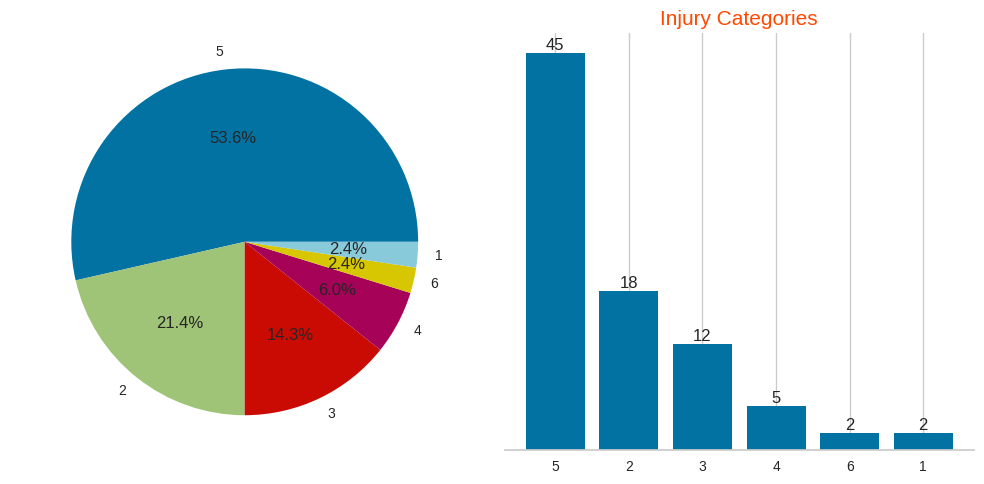

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

injury_categories = {6: '6', 5: '5', 4: '4', 3: '3', 2: '2', 1: '1'}

ax1.pie(sport_data[:]['Page'].value_counts().values,
        labels = np.array([injury_categories[page] for page in sport_data[:]['Page'].value_counts().index]),
        autopct = '%1.1f%%')

ax1.axis('equal')


ax2.bar(np.array([injury_categories[page] for page in sport_data[:]['Page'].value_counts().index]), sport_data[:]['Page'].value_counts().values)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='both', which='both', labelsize=10, left=False, bottom=False)
ax2.get_yaxis().set_visible(False)
plt.title("Injury Categories", fontsize=15, color = '#ff4800');

ax2.bar_label(ax2.containers[0])
fig.tight_layout()

Convert the nominal variables of the dataset to numerical variables.

In [9]:
pain                   = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
irritability           = {'a': 0, 'b': 1, 'c':2}
severity               = {
                          'RUNNING': {'a': 0, 'b': 1, 'c': 2},
                          'LIFE_MOBILITY': {'a': 0, 'b': 1}
                        }

In [10]:
# Pain Intensity
sport_data['Pain intensity'] = [pain[sport_data['Pain intensity'][row]] for row in range(sport_data.shape[0])]

# Irritability(WHEN, DURATION, INTENSITY)
sport_data['Irritability(WHEN)'] = [irritability[sport_data['Irritability(WHEN)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(DURATION)'] = [irritability[sport_data['Irritability(DURATION)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(INTENSITY)'] = [irritability[sport_data['Irritability(INTENSITY)'][row]] for row in range(sport_data.shape[0])]

# Severity(RUNNING)
sport_data['Severity(RUNNING)'] = [severity['RUNNING'][sport_data['Severity(RUNNING)'][row]] for row in range(sport_data.shape[0])]

# Severity(LIFE, MOBILITY)
sport_data['Severity(LIFE)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(LIFE)'][row]] for row in range(sport_data.shape[0])]
sport_data['Severity(MOBILITY)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(MOBILITY)'][row]] for row in range(sport_data.shape[0])]

In [11]:
sport_data['Pain intensity']          = sport_data['Pain intensity'].astype('int64')
sport_data['Irritability(WHEN)']      = sport_data['Irritability(WHEN)'].astype('int64')
sport_data['Irritability(DURATION)']  = sport_data['Irritability(DURATION)'].astype('int64')
sport_data['Irritability(INTENSITY)'] = sport_data['Irritability(INTENSITY)'].astype('int64')
sport_data['Severity(RUNNING)']       = sport_data['Severity(RUNNING)'].astype('int64')
sport_data['Severity(LIFE)']          = sport_data['Severity(LIFE)'].astype('int64')
sport_data['Severity(MOBILITY)']      = sport_data['Severity(MOBILITY)'].astype('int64')

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,Male,45,3.0,Calf,0,0,0,0,0,0,0,5
1,85,176,Male,45,4.0,Sole,0,0,0,0,0,0,0,5
2,25,154,Female,45,5.0,Knee,2,1,2,1,1,0,0,5
3,55,176,Male,38,9.0,Knee,2,2,1,1,2,0,1,5
4,56,170,Female,51,2.0,Hip,1,1,1,2,0,1,1,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Weight                   84 non-null     int64  
 1   Height                   84 non-null     int64  
 2   Gender                   84 non-null     object 
 3   Age                      84 non-null     int64  
 4   Experience               81 non-null     float64
 5   Symptom area             84 non-null     object 
 6   Pain intensity           84 non-null     int64  
 7   Irritability(WHEN)       84 non-null     int64  
 8   Irritability(DURATION)   84 non-null     int64  
 9   Irritability(INTENSITY)  84 non-null     int64  
 10  Severity(RUNNING)        84 non-null     int64  
 11  Severity(LIFE)           84 non-null     int64  
 12  Severity(MOBILITY)       84 non-null     int64  
 13  Page                     84 non-null     int64  
dtypes: float64(1), int64(11), ob

In [12]:
symptom_area = {
    'Calf': 0,
    'Hip': 1,
    'Knee': 2,
    'Low back': 3,
    'Sole': 4,
    'Thigh': 5
}
gender = {
    'Male':0,
    'Female':1
}

In [13]:
# Run this cell and the 2 below, only if you want to keep the original dataset
sport_data['Gender'] = [gender[sport_data['Gender'][row]] for row in range(sport_data.shape[0])]
sport_data['Symptom area'] = [symptom_area[sport_data['Symptom area'][row]] for row in range(sport_data.shape[0])]

In [14]:
sport_data['Gender']          = sport_data['Gender'].astype('int64')
sport_data['Symptom area']    = sport_data['Symptom area'].astype('int64')

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,0,45,3.0,0,0,0,0,0,0,0,0,5
1,85,176,0,45,4.0,4,0,0,0,0,0,0,0,5
2,25,154,1,45,5.0,2,2,1,2,1,1,0,0,5
3,55,176,0,38,9.0,2,2,2,1,1,2,0,1,5
4,56,170,1,51,2.0,1,1,1,1,2,0,1,1,3


## Dataset A
Dataset A contains all the features of the original dataset plus some additional samples for classes 6, 1 and 4.

- Weight
- Height
- Gender
- Age
- Experience
- Symptom area
- Pain intensity
- Irritability(WHEN)
- Irritability(DURATION)
- Irritability(INTENSITY)
- Severity(RUNNING)
- Severity(LIFE)
- Severity(MOBILITY)

In [15]:
sport_data_classification_A = sport_data.copy(deep=True)

In [ ]:
# Print the samples for class 1
sport_data_classification_A.loc[sport_data_classification_A['Page'] == 1]

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
57,80,178,0,45,3.0,2,0,2,2,2,0,1,1,1
61,82,168,1,25,15.0,5,0,2,2,2,0,1,1,1


In [16]:
# Add some additional samples for class 1.
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[70, 181, 0, 23, 2.0, 0, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[65, 175, 1, 30, 4.0, 4, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[77, 185, 0, 38, 3.0, 2, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[85, 190, 0, 27, 1.0, 3, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)

In [ ]:
# Print the samples for class 6
sport_data_classification_A.loc[sport_data_classification_A['Page'] == 6]

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
15,63,151,0,32,4.0,1,3,1,0,0,1,1,1,6
38,65,170,0,21,7.0,0,3,2,2,0,2,0,1,6


In [17]:
# Add some additional samples for class 6.
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[68, 179, 0, 33, 3.0, 4, 3, 0, 1, 1, 1, 1, 0, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[71, 166, 1, 25, 2.0, 2, 3, 2, 2, 2, 2, 1, 0, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[70, 175, 0, 36, 5.0, 3, 3, 1, 0, 0, 1, 0, 1, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[62, 153, 1, 23, 1.0, 0, 3, 2, 2, 0, 2, 1, 1, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)

In [ ]:
# Print the samples for class 4
sport_data_classification_A.loc[sport_data_classification_A['Page'] == 4]

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
6,80,183,0,46,5.0,2,1,1,1,2,1,1,1,4
9,56,170,1,50,20.0,3,1,0,2,2,1,1,1,4
16,54,175,1,58,4.0,1,1,1,0,0,1,1,1,4
29,87,181,0,29,13.0,2,1,2,1,2,1,1,1,4
78,71,180,1,23,0.0,1,1,0,2,0,1,1,1,4


In [18]:
# Add some additional samples for class 4.
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[75, 180, 0, 30, 4.0, 3, 0, 1, 0, 1, 1, 1, 1, 4]], columns=sport_data_classification_A.columns)], ignore_index = True)

## Dataset B
Dataset B contains all the features of the original dataset. Seven features of the original dataset are combined into three new features named:

- PAIN(Pain intensity)
- IRRITABILITY(Irritability(WHEN), Irritability(DURATION), Irritability(INTENSITY))
- SEVERITY(Severity(RUNNING), Severity(LIFE), Severity(MOBILITY))


Create a dataset that contains all the rows of the original dataset, but with the seven features combined into three new features.

In [19]:
data = {
    'Weight': list(sport_data['Weight'][:]),
    'height': list(sport_data['Height'][:]),
    'Gender': list(sport_data['Gender'][:]),
    'Age': list(sport_data['Age'][:]),
    'Experience': list(sport_data['Experience'][:]),
    'Symptom area': list(sport_data['Symptom area'][:]),
    'PAIN': [],
    'IRRITABILITY': [],
    'SEVERITY': [],
    'Page': list(sport_data['Page'][:]),
}

for row in range(sport_data.shape[0]):
  factor_list = create_main_factor_list(sport_data.iloc[row], 6)
  data['PAIN'].append(factor_list[0])
  data['IRRITABILITY'].append(factor_list[1])
  data['SEVERITY'].append(factor_list[2])


# Create a new dataframe for classification
sport_data_classification_B = pd.DataFrame(data=data)

In [ ]:
sport_data_classification_B.head()

,Weight,height,Gender,Age,Experience,Symptom area,PAIN,IRRITABILITY,SEVERITY,Page
0,84,176,0,45,3.0,0,0,2,2,5
1,85,176,0,45,4.0,4,0,2,2,5
2,25,154,1,45,5.0,2,2,1,2,5
3,55,176,0,38,9.0,2,2,1,2,5
4,56,170,1,51,2.0,1,1,1,0,3


Create a dataset that contains all the rows of the altered original dataset(sport_data_classification_A), but with the seven features combined into three new features.

In [20]:
data = {
    'Weight': list(sport_data_classification_A['Weight'][:]),
    'height': list(sport_data_classification_A['Height'][:]),
    'Gender': list(sport_data_classification_A['Gender'][:]),
    'Age': list(sport_data_classification_A['Age'][:]),
    'Experience': list(sport_data_classification_A['Experience'][:]),
    'Symptom area': list(sport_data_classification_A['Symptom area'][:]),
    'PAIN': [],
    'IRRITABILITY': [],
    'SEVERITY': [],
    'Page': list(sport_data_classification_A['Page'][:]),
}

for row in range(sport_data_classification_A.shape[0]):
  factor_list = create_main_factor_list(sport_data_classification_A.iloc[row], 6)
  data['PAIN'].append(factor_list[0])
  data['IRRITABILITY'].append(factor_list[1])
  data['SEVERITY'].append(factor_list[2])


# Create a new dataframe for classification
sport_data_classification_B_altered = pd.DataFrame(data=data)

In [ ]:
sport_data_classification_B_altered.shape

(93, 10)

In [ ]:
sport_data_classification_B_altered.head()

,Weight,height,Gender,Age,Experience,Symptom area,PAIN,IRRITABILITY,SEVERITY,Page
0,84,176,0,45,3.0,0,0,2,2,5
1,85,176,0,45,4.0,4,0,2,2,5
2,25,154,1,45,5.0,2,2,1,2,5
3,55,176,0,38,9.0,2,2,1,2,5
4,56,170,1,51,2.0,1,1,1,0,3


# Classification

## Classification Helper Functions

In [100]:
# Visualize the decision tree
def show_decision_tree_classifier(model, features):
  dot_data = StringIO()
  export_graphviz(model,
                  out_file=dot_data,
                  filled=True,
                  rounded=True,
                  special_characters=True,
                  impurity=False,
                  precision=2,
                  rotate=True,
                  feature_names=features,
                  class_names=['1', '2', '3', '4', '5', '6'])

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('DecisionTree.png')

  return graph


## Decision Trees


Scikit-learn uses an optimized version of the CART algorithm and the implementation does not support categorical variables.

CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.

C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. The accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule's precondition if the accuracy of the rule improves without it.

ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

### Decision Tree Classifier 1

Decision tree classifier for three features of dataset B.  

- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data_classification_B[['PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_B_altered[['PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=42, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.9012345679012346
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.88      0.95      0.89         9
weighted avg       0.94      0.89      0.90         9

Test Size: 0.15, F-Score: 0.927810650887574
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       1.00      0.86      0.92         7

    accuracy                           0.92        13
   macro avg       0.92      0.96      0.93        13
weighted avg       0.95      0.92      0.93        13

Test Siz

In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix:')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.86
Confusion Matrix:
              precision    recall  f1-score   support

           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.73      0.80      0.76        10
weighted avg       0.83      0.90      0.86        10

Test Size: 0.15, F-Score: 0.9
Confusion Matrix:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         1

    accuracy                       

#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTE().fit_resample(new_altered_classification_data[['PAIN', 'IRRITABILITY', 'SEVERITY']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  page = classify_sample(new_altered_classification_data.iloc[sample_row], 0)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break

print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 18. Identical samples: 17


I will train a model using the SMOTE altered resampled classification dataset and then test it by generating samples that do not exist in that training dataset.

In [ ]:
# Print the number of unique samples from each category(page)
for page in range(1,7):
  page_unique_samples = np.unique(new_altered_classification_data[new_altered_classification_data['Page'] == page].to_numpy(), axis=0).shape[0]
  print(f'Page: {page}\nUnique Samples: {page_unique_samples}\n')

Page: 1
Unique Samples: 1

Page: 2
Unique Samples: 1

Page: 3
Unique Samples: 2

Page: 4
Unique Samples: 2

Page: 5
Unique Samples: 8

Page: 6
Unique Samples: 4



In [ ]:
# All possible values for the 3 features of the dataset
feature_values_combinations = [
    [0,1,2,3], # PAIN
    [0,1,2], # IRRITABILITY
    [0,1,2], # SEVERITY
]


# Generate all possible combinations
new_features_values = list(itertools.product(*feature_values_combinations))

In [ ]:
# Create a testing dataset that contains all the possible combinations of the feature values that do not exist in the SMOTE altered resampled dataset
non_identical_samples = []


number_of_identical_samples = 0
for combination in new_features_values:
  identical = False
  for sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
    if (np.array(list(combination)) == sample[:-1]).all():
      identical = True
      number_of_identical_samples += 1
      break

  if not identical:
    non_identical_samples.append(list(combination))

print(f'Identical samples: {number_of_identical_samples}')

testing_data= []
for row in range(len(non_identical_samples)):
  factor_list = non_identical_samples[row]
  page = classify_factor_list(factor_list)
  if 1 <= page <= 6:
    non_identical_samples[row].append(page)
    testing_data.append(non_identical_samples[row])

testing_data = np.array(testing_data)

testing_classification_data = pd.DataFrame(data=testing_data, columns=list(new_altered_classification_data.columns))

Identical samples: 18


In [ ]:
# Create a testing dataset that contains all the possible combinations of the feature values
combinations = [list(combination) for combination in new_features_values]

testing_data= []
for row in range(len(combinations)):
  factor_list = combinations[row]
  page = classify_factor_list(factor_list)
  if 1 <= page <= 6:
    combinations[row].append(page)
    testing_data.append(combinations[row])

testing_data = np.array(testing_data)

testing_classification_data = pd.DataFrame(data=testing_data, columns=list(new_altered_classification_data.columns))

In [ ]:
# Print the number of unique samples from each category(page)
"""
The unique samples from the testing_classification_data dataset represent the unique samples that don't exist in the new_altered_classification_data dataset

"""

for page in range(1,7):
  if page == 5:
    page_unique_samples = np.unique(testing_classification_data[(testing_classification_data['Page'] == page) & (testing_classification_data['PAIN'] != 2)].to_numpy(), axis=0).shape[0]
  else:
    page_unique_samples = np.unique(testing_classification_data[testing_classification_data['Page'] == page].to_numpy(), axis=0).shape[0]

  print(f'Page: {page}\nUnique Samples: {page_unique_samples}\n')

Page: 1
Unique Samples: 1

Page: 2
Unique Samples: 1

Page: 3
Unique Samples: 2

Page: 4
Unique Samples: 6

Page: 5
Unique Samples: 8

Page: 6
Unique Samples: 9



In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the generated samples that do not exist in the SMOTE resampled altered dataset
test = testing_classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         2
           4       0.67      1.00      0.80         6
           5       1.00      0.76      0.87        17
           6       1.00      1.00      1.00         9

    accuracy                           0.89        36
   macro avg       0.86      0.96      0.89        36
weighted avg       0.93      0.89      0.89        36



In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00         2

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=42, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='macro')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix:')
  print(classification_report(test['Page'], y_pred, zero_division=0))


Test Size: 0.1, F-Score: 0.9663299663299664
Confusion Matrix:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         4

    accuracy                           0.96        27
   macro avg       0.97      0.97      0.97        27
weighted avg       0.97      0.96      0.96        27

Test Size: 0.15, F-Score: 0.9760683760683762
Confusion Matrix:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         7
           5       1.00      0.86      0.92         7
       

### Decision Tree Classifier 2
Decision tree classifier for seven features of dataset A.  

- Pain
- Irritability(WHEN)
- Irritability(DURATION)
- Irritability(INTENSITY)
- Severity(RUNNING)
- Severity(LIFE)
- Severity(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [53]:
# Classification data based on the unaltered original dataset
classification_data = sport_data[['Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [54]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A[[
                                  'Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [24]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=42, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.9012345679012346
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.88      0.95      0.89         9
weighted avg       0.94      0.89      0.90         9

Test Size: 0.15, F-Score: 0.927810650887574
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       1.00      0.86      0.92         7

    accuracy                           0.92        13
   macro avg       0.92      0.96      0.93        13
weighted avg       0.95      0.92      0.93        13

Test Siz

In [25]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.86
Confusion Matrix
              precision    recall  f1-score   support

           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.73      0.80      0.76        10
weighted avg       0.83      0.90      0.86        10

Test Size: 0.15, F-Score: 0.9
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         1

    accuracy                         

#### Classification with SMOTE for the Altered Dataset

In [55]:
# Split the altered original dataset into a training and testing set, and resample the training set with SMOTE
train, test = train_test_split(classification_data_altered, test_size=0.3, train_size=0.7, random_state=42, stratify=classification_data_altered.Page)

# Create a new training set
new_training_set = train.copy()

print("Training Set: \n",new_training_set.pivot_table(index='Page', aggfunc='size'))

training_set_class_samples = [
    new_training_set[new_training_set['Page'] == 1].shape[0],
    new_training_set[new_training_set['Page'] == 2].shape[0],
    new_training_set[new_training_set['Page'] == 3].shape[0],
    new_training_set[new_training_set['Page'] == 4].shape[0],
    new_training_set[new_training_set['Page'] == 5].shape[0],
    new_training_set[new_training_set['Page'] == 6].shape[0],
]

max_class_sample = max(training_set_class_samples)


sampling_strategy = [{1: max_class_sample}, {6:max_class_sample}, {4: max_class_sample}, 'auto']

# Define the k neighbors for each class
k_neighbors = [
           training_set_class_samples[0] - 1,
           training_set_class_samples[-1] - 1,
           training_set_class_samples[3] - 1,
           5
           ]

for i in range(4):
  resampled_data = SMOTE(k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i]).fit_resample(
    new_training_set[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])
  new_training_set = resampled_data[0]
  new_training_set['Page'] = resampled_data[1].to_numpy()

print(f'\nTrain: {train.shape}\nNew Train: {new_training_set.shape}\nTest: {test.shape}\n')
print("New Trainign Set: \n",new_training_set.pivot_table(index='Page', aggfunc='size'))

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(new_training_set[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']], new_training_set['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

Training Set: 
 Page
1     4
2    13
3     8
4     4
5    32
6     4
dtype: int64

Train: (65, 8)
New Train: (192, 8)
Test: (28, 8)

New Trainign Set: 
 Page
1    32
2    32
3    32
4    32
5    32
6    32
dtype: int64
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.71      1.00      0.83         5
           3       0.80      1.00      0.89         4
           4       1.00      0.50      0.67         2
           5       0.91      0.77      0.83        13
           6       1.00      1.00      1.00         2

    accuracy                           0.86        28
   macro avg       0.90      0.88      0.87        28
weighted avg       0.88      0.86      0.85        28



In [ ]:
plt.figure(figsize=(50,25))

plot_tree(clf,
          filled=True,
          rounded=True,
          impurity=False,
          precision=2,
          #label='root',
          proportion=False,
          feature_names=['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)'],
          class_names=['1', '2', '3', '4', '5', '6'],
          fontsize=36)

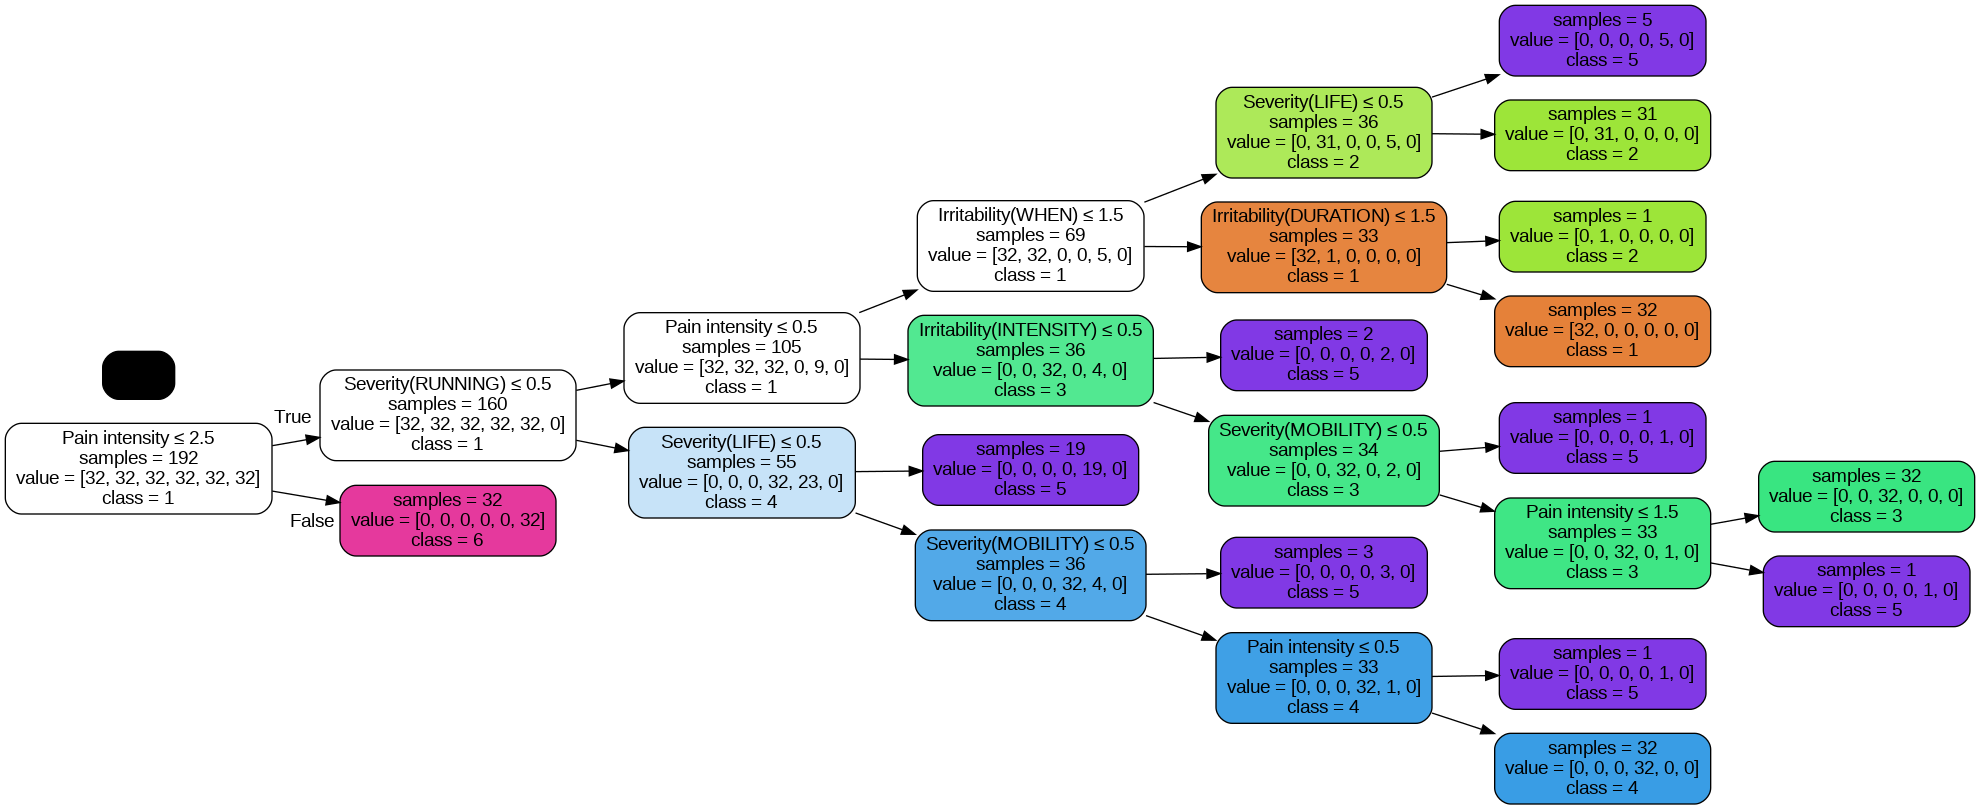

<Figure size 4000x3500 with 0 Axes>

In [105]:
# Decision Tree visualization using Graphviz
Image(show_decision_tree_classifier(clf, ['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']).create_png())

In [ ]:
# Count the number of unique samples in
# 1) the resampled training set
# 2) the original training set
# 3) the testing set
# 4) original altered dataset

print("Resampled training set: ")
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(new_training_set[new_training_set["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nOriginal training set: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(train[train["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nTesting set: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(test[test["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nOriginal altered dataset: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(classification_data_altered[classification_data_altered["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')

Resampled training set: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 7
Page: 3 Unique Samples: 5
Page: 4 Unique Samples: 9
Page: 5 Unique Samples: 31
Page: 6 Unique Samples: 12

Original training set: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 7
Page: 3 Unique Samples: 4
Page: 4 Unique Samples: 4
Page: 5 Unique Samples: 31
Page: 6 Unique Samples: 4

Testing set: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 4
Page: 3 Unique Samples: 2
Page: 4 Unique Samples: 2
Page: 5 Unique Samples: 13
Page: 6 Unique Samples: 2

Original altered dataset: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 7
Page: 3 Unique Samples: 6
Page: 4 Unique Samples: 6
Page: 5 Unique Samples: 42
Page: 6 Unique Samples: 6


In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()

sampling_strategy = [{6:45}, {4:45}, {1:45}, 'auto']
for i in range(4):
  resampled_data = SMOTE(sampling_strategy=sampling_strategy[i]).fit_resample(new_altered_classification_data[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
  new_altered_classification_data = resampled_data[0]
  new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 0)
  page = classify_factor_list(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break

print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 93. Identical samples: 68


I will train a model using the SMOTE altered resampled classification dataset and then test it by generating samples that do not exist in that training dataset.

In [ ]:
# Print the number of unique samples from each category(page)
for page in range(1,7):
  page_unique_samples = np.unique(new_altered_classification_data[new_altered_classification_data['Page'] == page].to_numpy()[:-1], axis=0).shape[0]
  print(f'Page: {page}\nUnique Samples: {page_unique_samples}\n')

Page: 1
Unique Samples: 1

Page: 2
Unique Samples: 8

Page: 3
Unique Samples: 6

Page: 4
Unique Samples: 17

Page: 5
Unique Samples: 41

Page: 6
Unique Samples: 19



In [ ]:
# All possible values for the 7 features of the dataset
feature_values_combinations = [
    [0,1,2,3], # Pain
    [0,1,2], # Irritability(WHEN)
    [0,1,2], # Irritability(DURATION)
    [0,1,2], # Irritability(INTENSITY)
    [0,1,2], # Severity(RUNNING)
    [0,1], # Severity(LIFE)
    [0,1] # Severity(MOBILITY)
]


# Generate all possible combinations
new_features_values = list(itertools.product(*feature_values_combinations))

In [ ]:
# Create a testing dataset that contains the feature values that do not exist in the SMOTE altered resampled dataset
non_identical_samples = []


number_of_identical_samples = 0
for combination in new_features_values:
  identical = False
  for sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
    if (np.array(list(combination)) == sample[:-1]).all():
      identical = True
      number_of_identical_samples += 1
      break

  if not identical:
    non_identical_samples.append(list(combination))

print(f'Identical samples: {number_of_identical_samples}')

testing_data= []
for row in range(len(non_identical_samples)):
  factor_list = create_main_factor_list(non_identical_samples[row], 0)
  page = classify_factor_list(factor_list)
  if 1 <= page <= 6:
    non_identical_samples[row].append(page)
    testing_data.append(non_identical_samples[row])

testing_data = np.array(testing_data)

testing_classification_data = pd.DataFrame(data=testing_data, columns=list(new_altered_classification_data.columns))

Identical samples: 93


In [ ]:
# Create a testing dataset that contains all the possible combinations of the feature values
combinations = [list(combination) for combination in new_features_values]

testing_data= []
for row in range(len(combinations)):
  factor_list = create_main_factor_list(combinations[row], 0)
  page = classify_factor_list(factor_list)
  if 1 <= page <= 6:
    combinations[row].append(page)
    testing_data.append(combinations[row])

testing_data = np.array(testing_data)

testing_classification_data = pd.DataFrame(data=testing_data, columns=list(new_altered_classification_data.columns))

In [ ]:
# Print the number of unique samples from each category(page)
"""
The unique samples from the testing_classification_data dataset represent the unique samples that don't exist in the new_altered_classification_data dataset

"""

for page in range(1,7):
  if page == 5:
    page_unique_samples = np.unique(testing_classification_data[(testing_classification_data['Page'] == page) & (testing_classification_data['Pain intensity'] != 2)].to_numpy(), axis=0).shape[0]
  else:
    page_unique_samples = np.unique(testing_classification_data[testing_classification_data['Page'] == page].to_numpy(), axis=0).shape[0]

  print(f'Page: {page}\nUnique Samples: {page_unique_samples}\n')

Page: 1
Unique Samples: 0

Page: 2
Unique Samples: 17

Page: 3
Unique Samples: 20

Page: 4
Unique Samples: 37

Page: 5
Unique Samples: 509

Page: 6
Unique Samples: 305



In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the generated samples that do not exist in the SMOTE resampled altered dataset
test = testing_classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.61      0.65      0.63        17
           3       1.00      0.60      0.75        20
           4       0.58      1.00      0.73        37
           5       0.98      0.95      0.97       824
           6       1.00      1.00      1.00       305

    accuracy                           0.95      1203
   macro avg       0.70      0.70      0.68      1203
weighted avg       0.97      0.95      0.96      1203



In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00         2

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=42, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])
  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='macro')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.9663299663299664
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         4

    accuracy                           0.96        27
   macro avg       0.97      0.97      0.97        27
weighted avg       0.97      0.96      0.96        27

Test Size: 0.15, F-Score: 0.9500000000000001
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7
           4       0.88      1.00      0.93         7
           5       1.00      0.71      0.83         7
         

In [ ]:
Image(show_decision_tree_classifier(model_score[0.30][1], ['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']).create_png())

### Decision Tree Classifier 3
Decision tree classifier for eight features of dataset A.
  - Symptom area
  -  Pain
  -  Irritability(WHEN)
  -  Irritability(DURATION)
  -  Irritability(INTENSITY)
  -  Severity(RUNNING)
  -  Severity(LIFE)
  -  Severity(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data[['Symptom area',
                                  'Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A[['Symptom area', 'Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=42, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])
  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))


Test Size: 0.1, F-Score: 0.9012345679012346
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.88      0.95      0.89         9
weighted avg       0.94      0.89      0.90         9

Test Size: 0.15, F-Score: 0.927810650887574
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       1.00      0.86      0.92         7

    accuracy                           0.92        13
   macro avg       0.92      0.96      0.93        13
weighted avg       0.95      0.92      0.93        13

Test Siz

In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.86
Confusion Matrix
              precision    recall  f1-score   support

           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.73      0.80      0.76        10
weighted avg       0.83      0.90      0.86        10

Test Size: 0.15, F-Score: 0.9
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         1

    accuracy                         

#### Classification with SMOTE for the Altered Dataset


In [ ]:
# Split the altered original dataset into a training and testing set, and resample the training set with SMOTE
train, test = train_test_split(classification_data_altered, test_size=0.3, train_size=0.7, random_state=42, stratify=classification_data_altered.Page)

# Create a new training set
new_training_set = train.copy()

print(new_training_set.pivot_table(index='Page', aggfunc='size'))

training_set_class_samples = [
    new_training_set[new_training_set['Page'] == 1].shape[0],
    new_training_set[new_training_set['Page'] == 2].shape[0],
    new_training_set[new_training_set['Page'] == 3].shape[0],
    new_training_set[new_training_set['Page'] == 4].shape[0],
    new_training_set[new_training_set['Page'] == 5].shape[0],
    new_training_set[new_training_set['Page'] == 6].shape[0],
]

max_class_sample = max(training_set_class_samples)


sampling_strategy = [{1: max_class_sample}, {6:max_class_sample}, {4: max_class_sample}, 'auto']

# Define the k neighbors for each class
k_neighbors = [
           training_set_class_samples[0] - 1,
           training_set_class_samples[-1] - 1,
           training_set_class_samples[3] - 1,
           5
           ]

for i in range(4):
  resampled_data = SMOTE(k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i]).fit_resample(
    new_training_set[['Symptom area','Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])
  new_training_set = resampled_data[0]
  new_training_set['Page'] = resampled_data[1].to_numpy()

print(f'\nTrain: {train.shape}\nNew Train: {new_training_set.shape}\nTest: {test.shape}\n')
print(new_training_set.pivot_table(index='Page', aggfunc='size'))

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(new_training_set[['Symptom area','Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']], new_training_set['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Symptom area','Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

Page
1     4
2    13
3     8
4     4
5    32
6     4
dtype: int64

Train: (65, 9)
New Train: (192, 9)
Test: (28, 9)

Page
1    32
2    32
3    32
4    32
5    32
6    32
dtype: int64
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.71      1.00      0.83         5
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         2
           5       1.00      0.77      0.87        13
           6       1.00      1.00      1.00         2

    accuracy                           0.89        28
   macro avg       0.92      0.96      0.93        28
weighted avg       0.92      0.89      0.89        28



In [ ]:
# Count the number of unique samples in
# 1) the resampled training set
# 2) the original training set
# 3) the testing set

print("Resampled training set: ")
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(new_training_set[new_training_set["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nOriginal training set: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(train[train["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nTesting set: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(test[test["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nOriginal altered dataset: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(classification_data_altered[classification_data_altered["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')

Resampled training set: 
Page: 1 Unique Samples: 6
Page: 2 Unique Samples: 16
Page: 3 Unique Samples: 7
Page: 4 Unique Samples: 9
Page: 5 Unique Samples: 31
Page: 6 Unique Samples: 15

Original training set: 
Page: 1 Unique Samples: 4
Page: 2 Unique Samples: 12
Page: 3 Unique Samples: 4
Page: 4 Unique Samples: 4
Page: 5 Unique Samples: 31
Page: 6 Unique Samples: 4

Testing set: 
Page: 1 Unique Samples: 2
Page: 2 Unique Samples: 4
Page: 3 Unique Samples: 4
Page: 4 Unique Samples: 2
Page: 5 Unique Samples: 13
Page: 6 Unique Samples: 2

Original altered dataset: 
Page: 1 Unique Samples: 5
Page: 2 Unique Samples: 14
Page: 3 Unique Samples: 8
Page: 4 Unique Samples: 6
Page: 5 Unique Samples: 44
Page: 6 Unique Samples: 6


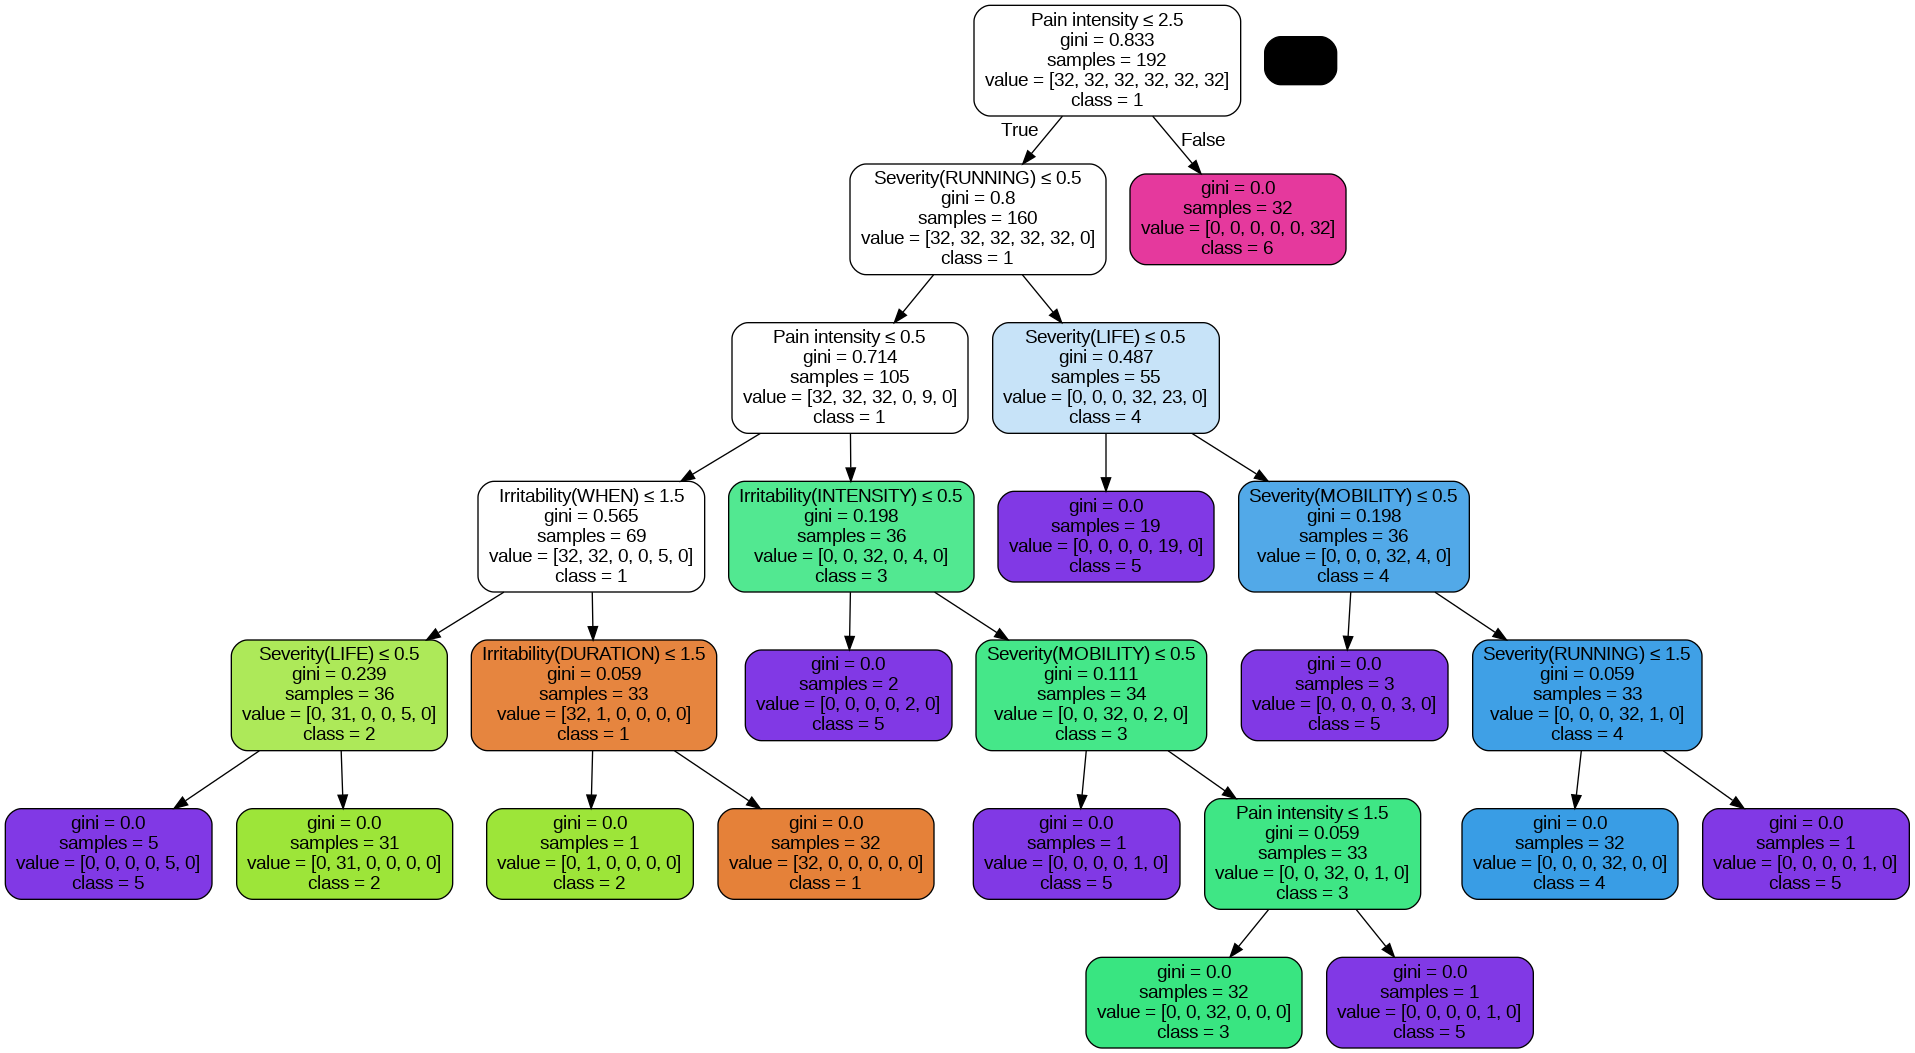

In [ ]:
Image(show_decision_tree_classifier(clf, ['Symptom area','Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']).create_png())

In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTE().fit_resample(new_altered_classification_data[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
new_altered_classification_data.pivot_table(index='Page', aggfunc='size')

Page
1    45
2    45
3    45
4    45
5    45
6    45
dtype: int64

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 1)
  page = classify_factor_list(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break

print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 123. Identical samples: 83


In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=42, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='macro')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))


Test Size: 0.1, F-Score: 0.9663299663299664
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         4

    accuracy                           0.96        27
   macro avg       0.97      0.97      0.97        27
weighted avg       0.97      0.96      0.96        27

Test Size: 0.15, F-Score: 0.9500000000000001
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7
           4       0.88      1.00      0.93         7
           5       1.00      0.71      0.83         7
         

In [ ]:
Image(show_decision_tree_classifier(model_score[0.35][1], ['Symptom area','Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']).create_png())

### Decision Tree Classifier 4
Decision tree classifier for all features of dataset A.  

- Weight
- Height
- Gender
- Age
- Experience
- Symptom area
- Pain intensity
- Irritability(WHEN)
- Irritability(DURATION)
- Irritability(INTENSITY)
- Severity(RUNNING)
- Severity(LIFE)
- Severity(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data

classification_data = classification_data.dropna()

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A

classification_data_altered = classification_data_altered.dropna()

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=1, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.8383838383838383
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.83      1.00      0.91         5

    accuracy                           0.89         9
   macro avg       0.71      0.75      0.73         9
weighted avg       0.80      0.89      0.84         9

Test Size: 0.15, F-Score: 1.0
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         7

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

Test Size: 0.2, F-Scor

In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.7439153439153439
Confusion Matrix
              precision    recall  f1-score   support

           2       0.67      1.00      0.80         2
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       1.00      0.75      0.86         4
           6       1.00      1.00      1.00         1

    accuracy                           0.78         9
   macro avg       0.63      0.75      0.66         9
weighted avg       0.76      0.78      0.74         9

Test Size: 0.15, F-Score: 0.8304267161410017
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.75      1.00      0.86         3
           3       0.67      1.00      0.80         2
           4       0.00      0.00      0.00         1
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         1

    accu

#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Split the altered original dataset into a training and testing set, and resample the training set with SMOTE
train, test = train_test_split(classification_data_altered, test_size=0.3, train_size=0.7, random_state=42, stratify=classification_data_altered.Page)

# Create a new training set
new_training_set = train.copy()

print("Training Set: \n",new_training_set.pivot_table(index='Page', aggfunc='size'))

training_set_class_samples = [
    new_training_set[new_training_set['Page'] == 1].shape[0],
    new_training_set[new_training_set['Page'] == 2].shape[0],
    new_training_set[new_training_set['Page'] == 3].shape[0],
    new_training_set[new_training_set['Page'] == 4].shape[0],
    new_training_set[new_training_set['Page'] == 5].shape[0],
    new_training_set[new_training_set['Page'] == 6].shape[0],
]

max_class_sample = max(training_set_class_samples)


sampling_strategy = [{1: max_class_sample}, {6:max_class_sample}, {4: max_class_sample}, 'auto']

# Define the k neighbors for each class
k_neighbors = [
           training_set_class_samples[0] - 1,
           training_set_class_samples[-1] - 1,
           training_set_class_samples[3] - 1,
           5
           ]

for i in range(4):
  resampled_data = SMOTENC(k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i], categorical_features=[2,5,6,7,8,9,10,11,12]).fit_resample(
    new_training_set[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])
  new_training_set = resampled_data[0]
  new_training_set['Page'] = resampled_data[1].to_numpy()

print(f'\nTrain: {train.shape}\nNew Train: {new_training_set.shape}\nTest: {test.shape}\n')
print("New Trainign Set: \n",new_training_set.pivot_table(index='Page', aggfunc='size'))

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(new_training_set[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

Training Set: 
 Page
1     4
2    13
3     8
4     4
5    29
6     4
dtype: int64

Train: (62, 14)
New Train: (174, 14)
Test: (27, 14)

New Trainign Set: 
 Page
1    29
2    29
3    29
4    29
5    29
6    29
dtype: int64
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         2
           2       0.80      0.80      0.80         5
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         2
           5       0.91      0.83      0.87        12
           6       1.00      1.00      1.00         2

    accuracy                           0.81        27
   macro avg       0.67      0.77      0.70        27
weighted avg       0.78      0.81      0.79        27



In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTENC(categorical_features=[2,5,6,7,8,9,10,11,12]).fit_resample(new_altered_classification_data[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 6)
  page = classify_factor_list(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break

print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 250. Identical samples: 90


In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        42
           6       1.00      1.00      1.00         2

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=42, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='macro')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.9145299145299146
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         5
           5       1.00      0.50      0.67         4
           6       1.00      1.00      1.00         5

    accuracy                           0.92        26
   macro avg       0.93      0.92      0.91        26
weighted avg       0.94      0.92      0.91        26

Test Size: 0.15, F-Score: 0.88796992481203
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       0.86      1.00      0.92         6
           3       0.75      1.00      0.86         6
           4       1.00      0.86      0.92         7
           5       0.75      0.50      0.60         6
           

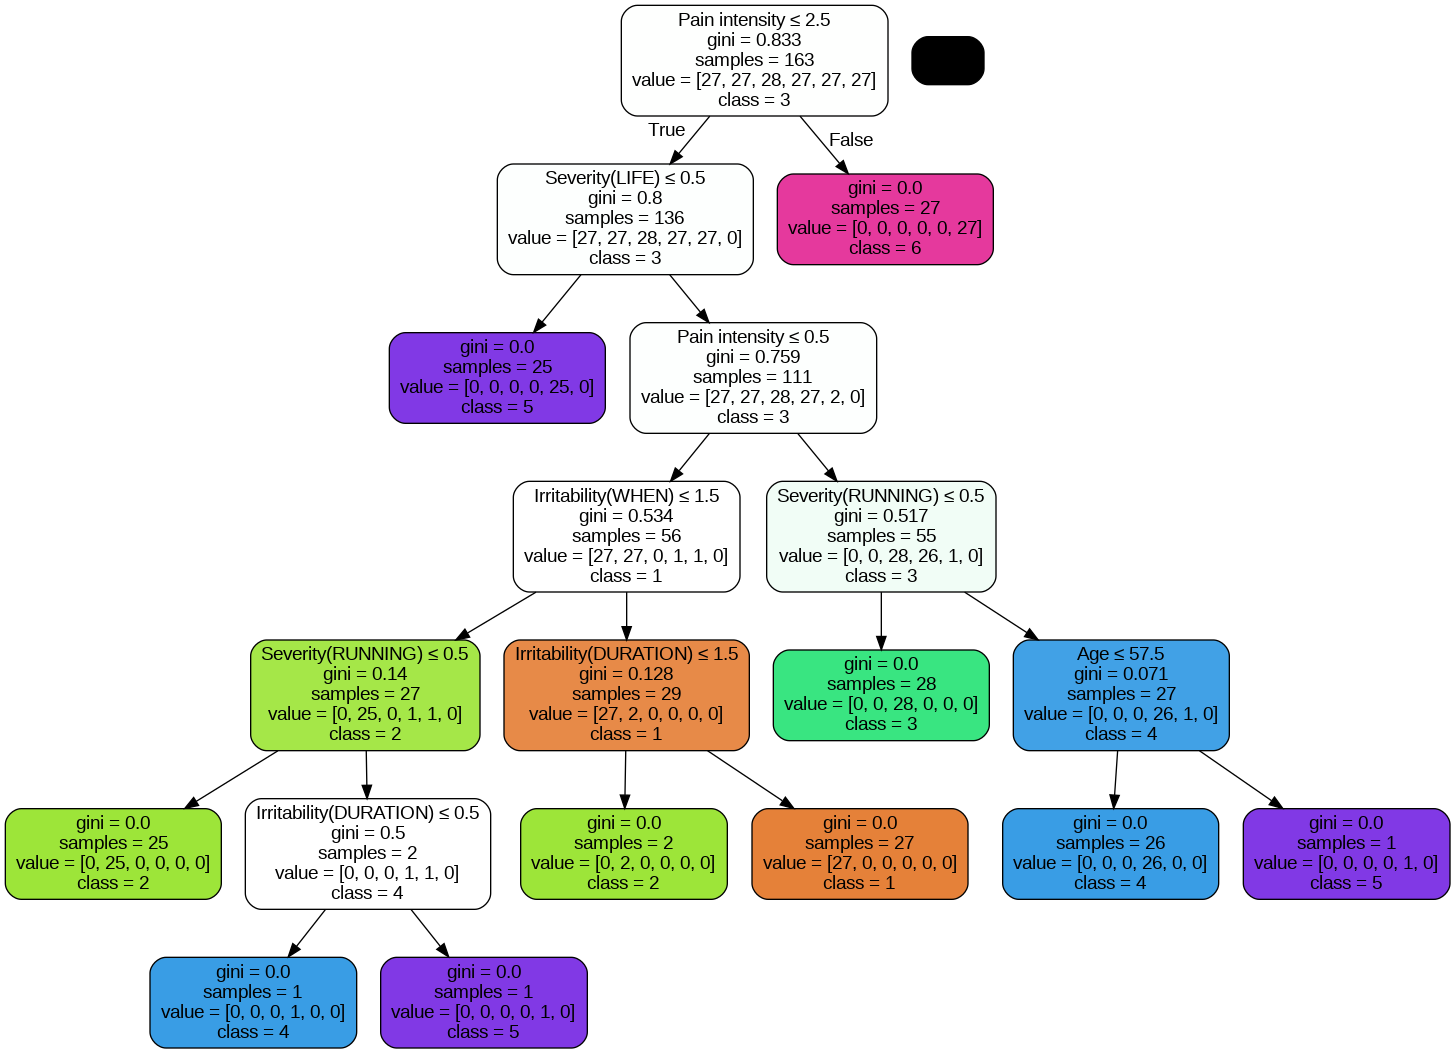

In [ ]:
Image(show_decision_tree_classifier(model_score[0.35][1], ['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']).create_png())

## Random Forests

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

### Random Forests 1
Random forests for seven features of dataset A.

- Pain
- Irritability(WHEN)
- Irritability(DURATION)
- Irritability(INTENSITY)
- Severity(RUNNING)
- Severity(LIFE)
- Severity(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data[['Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A[[
                                  'Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=42, stratify=classification_data.Page)

  # Create the Random Forests
  rf = RandomForestClassifier()

  # Train the Random Forests classifier
  rf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response
  y_pred = rf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, rf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.8055555555555556
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       0.33      1.00      0.50         1
           4       1.00      1.00      1.00         1
           5       1.00      0.60      0.75         5

    accuracy                           0.78         9
   macro avg       0.83      0.90      0.81         9
weighted avg       0.93      0.78      0.81         9

Test Size: 0.15, F-Score: 0.8589743589743589
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         1
           5       1.00      0.71      0.83         7

    accuracy                           0.85        13
   macro avg       0.88      0.93      0.88        13
weighted avg       0.92      0.85      0.86        13

Test Si

In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create the Random Forests
  rf = RandomForestClassifier()

  # Train the Random Forests classifier
  rf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response
  y_pred = rf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, rf]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.6266666666666667
Confusion Matrix
              precision    recall  f1-score   support

           2       0.67      1.00      0.80         2
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       0.80      0.80      0.80         5
           6       0.00      0.00      0.00         1

    accuracy                           0.70        10
   macro avg       0.39      0.56      0.45        10
weighted avg       0.58      0.70      0.63        10

Test Size: 0.15, F-Score: 0.7946428571428571
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         1
           5       0.78      1.00      0.88         7
           6       0.00      0.00      0.00         1

    accu

#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Split the altered original dataset into a training and testing set, and resample the training set with SMOTE
train, test = train_test_split(classification_data_altered, test_size=0.3, train_size=0.7, random_state=42, stratify=classification_data_altered.Page)

# Create a new training set
new_training_set = train.copy()

print(new_training_set.pivot_table(index='Page', aggfunc='size'))

training_set_class_samples = [
    new_training_set[new_training_set['Page'] == 1].shape[0],
    new_training_set[new_training_set['Page'] == 2].shape[0],
    new_training_set[new_training_set['Page'] == 3].shape[0],
    new_training_set[new_training_set['Page'] == 4].shape[0],
    new_training_set[new_training_set['Page'] == 5].shape[0],
    new_training_set[new_training_set['Page'] == 6].shape[0],
]

max_class_sample = max(training_set_class_samples)


sampling_strategy = [{1: max_class_sample}, {6:max_class_sample}, {4: max_class_sample}, 'auto']

# Define the k neighbors for each class
k_neighbors = [
           training_set_class_samples[0] - 1,
           training_set_class_samples[-1] - 1,
           training_set_class_samples[3] - 1,
           5
           ]

for i in range(4):
  resampled_data = SMOTE(k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i]).fit_resample(
    new_training_set[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])
  new_training_set = resampled_data[0]
  new_training_set['Page'] = resampled_data[1].to_numpy()

print(f'\nTrain: {train.shape}\nNew Train: {new_training_set.shape}\nTest: {test.shape}\n')
print(new_training_set.pivot_table(index='Page', aggfunc='size'))

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}


# Create the Random Forests classifer object
rf = RandomForestClassifier()


# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Train the Random Forests Classifer
rand_search = rand_search.fit(new_training_set[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']], new_training_set['Page'])


# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Page
1     4
2    13
3     8
4     4
5    32
6     4
dtype: int64

Train: (65, 8)
New Train: (192, 8)
Test: (28, 8)

Page
1    32
2    32
3    32
4    32
5    32
6    32
dtype: int64
Best hyperparameters: {'max_depth': 16, 'n_estimators': 393}


In [ ]:
# Create the Random Forests classifer object
rf_classifier = RandomForestClassifier(n_estimators=393, max_depth=16)

# Train the Random Forests Classifer
rf_classifier.fit(new_training_set[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']], new_training_set['Page'])

# Predict the response for test dataset
y_pred = rf_classifier.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                      'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                      'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.83      1.00      0.91         5
           3       0.80      1.00      0.89         4
           4       1.00      0.50      0.67         2
           5       0.92      0.85      0.88        13
           6       1.00      1.00      1.00         2

    accuracy                           0.89        28
   macro avg       0.93      0.89      0.89        28
weighted avg       0.90      0.89      0.89        28



In [ ]:
# Count the number of unique samples in
# 1) the resampled training set
# 2) the original training set
# 3) the testing set

print("Resampled training set: ")
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(new_training_set[new_training_set["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nOriginal training set: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(train[train["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nTesting set: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(test[test["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')


print(f'\nOriginal altered dataset: ')
for i in range(1,7):
  print(f'Page: {i} Unique Samples: {np.unique(classification_data_altered[classification_data_altered["Page"] == i].to_numpy()[:, :-1], axis=0).shape[0]}')

Resampled training set: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 8
Page: 3 Unique Samples: 5
Page: 4 Unique Samples: 9
Page: 5 Unique Samples: 31
Page: 6 Unique Samples: 12

Original training set: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 7
Page: 3 Unique Samples: 4
Page: 4 Unique Samples: 4
Page: 5 Unique Samples: 31
Page: 6 Unique Samples: 4

Testing set: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 4
Page: 3 Unique Samples: 2
Page: 4 Unique Samples: 2
Page: 5 Unique Samples: 13
Page: 6 Unique Samples: 2

Original altered dataset: 
Page: 1 Unique Samples: 1
Page: 2 Unique Samples: 7
Page: 3 Unique Samples: 6
Page: 4 Unique Samples: 6
Page: 5 Unique Samples: 42
Page: 6 Unique Samples: 6


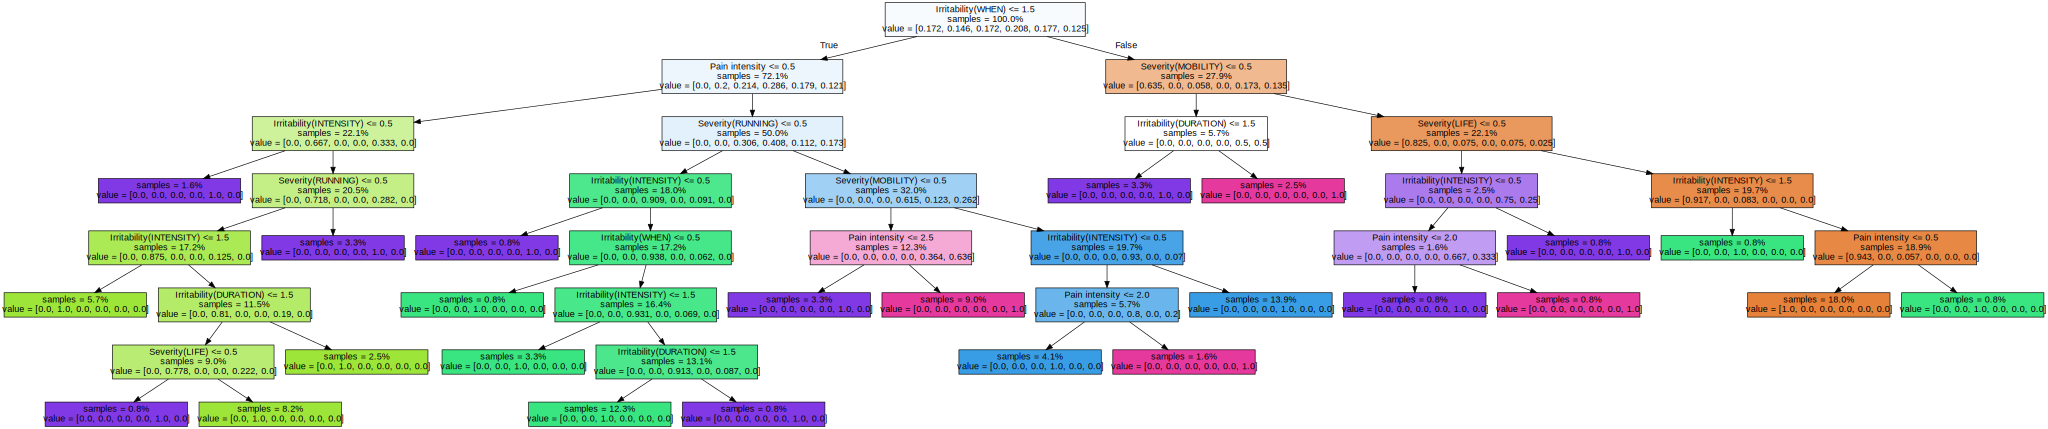

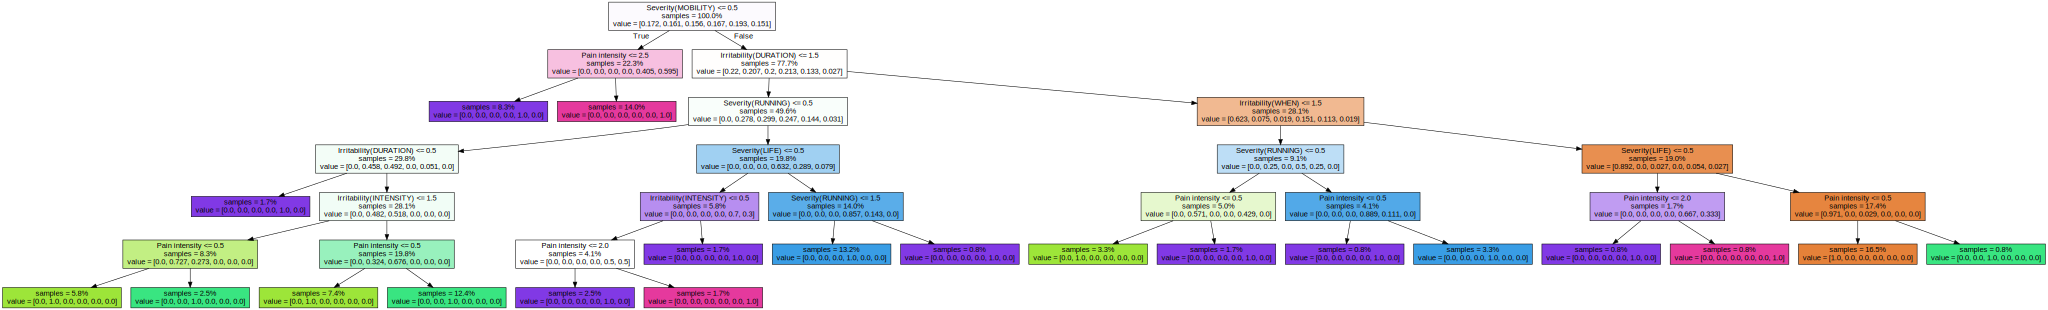

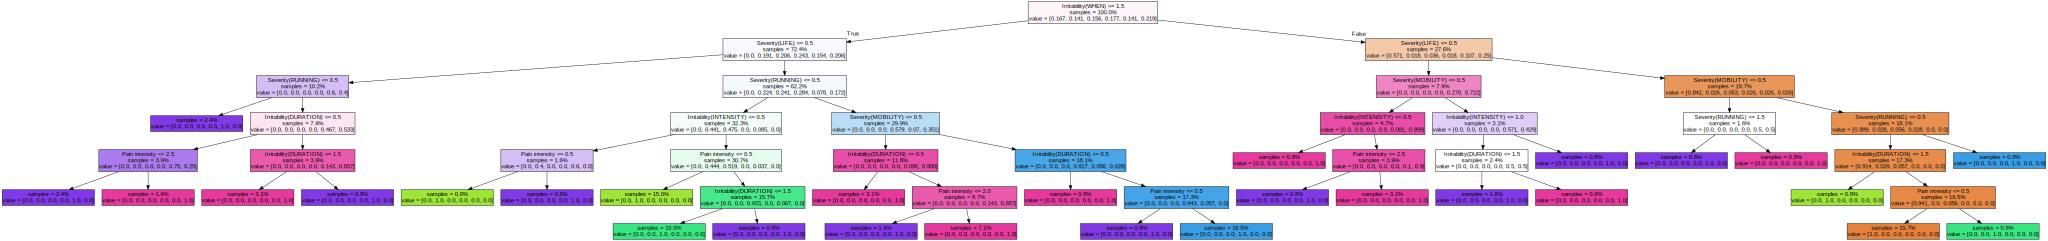

In [ ]:
# Print 3 decision trees in the random forest
for i in range(3):
  tree = rf_classifier.estimators_[i]
  dot_data = export_graphviz(tree,
                               feature_names=['Pain intensity','Irritability(WHEN)','Irritability(DURATION)','Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)','Severity(MOBILITY)'],
                               filled=True,
                               impurity=False,
                               proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)

## Bayes Classifier

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable

### Gaussian Naive Bayes 1

Gaussian Naive Bayes classifier for seven features of dataset A.

- Pain intensity
- Irritability(WHEN)
- Irritability(DURATION)
- Irritability(INTENSITY)
- Severity(RUNNING)
- Severity(LIFE)
- Severity(MOBILITY)


In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data[['Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A[['Pain intensity',
                                  'Irritability(WHEN)',
                                  'Irritability(DURATION)',
                                  'Irritability(INTENSITY)',
                                  'Severity(RUNNING)',
                                  'Severity(LIFE)',
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=42, stratify=classification_data.Page)

  # Create the Gaussian Naive Bayes object
  gnb = GaussianNB()

  # Train GNB
  gnb = gnb.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = gnb.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, gnb]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.9012345679012346
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.88      0.95      0.89         9
weighted avg       0.94      0.89      0.90         9

Test Size: 0.15, F-Score: 0.927810650887574
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       1.00      0.86      0.92         7

    accuracy                           0.92        13
   macro avg       0.92      0.96      0.93        13
weighted avg       0.95      0.92      0.93        13

Test Siz

In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create the Gaussian Naive Bayes object
  gnb = GaussianNB()

  # Train GNB
  gnb = gnb.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = gnb.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, gnb]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.8545454545454545
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.77      0.80      0.78        10
weighted avg       0.82      0.90      0.85        10

Test Size: 0.15, F-Score: 0.8952380952380953
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         1
           5       0.88      1.00      0.93         7
           6       1.00      1.00      1.00         1

    accu

#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Split the altered original dataset into a training and testing set, and resample the training set with SMOTE
train, test = train_test_split(classification_data_altered, test_size=0.3, train_size=0.7, random_state=42, stratify=classification_data_altered.Page)

# Create a new training set
new_training_set = train.copy()

print(new_training_set.pivot_table(index='Page', aggfunc='size'))

training_set_class_samples = [
    new_training_set[new_training_set['Page'] == 1].shape[0],
    new_training_set[new_training_set['Page'] == 2].shape[0],
    new_training_set[new_training_set['Page'] == 3].shape[0],
    new_training_set[new_training_set['Page'] == 4].shape[0],
    new_training_set[new_training_set['Page'] == 5].shape[0],
    new_training_set[new_training_set['Page'] == 6].shape[0],
]

max_class_sample = max(training_set_class_samples)


sampling_strategy = [{1: max_class_sample}, {6:max_class_sample}, {4: max_class_sample}, 'auto']

# Define the k neighbors for each class
k_neighbors = [
           training_set_class_samples[0] - 1,
           training_set_class_samples[-1] - 1,
           training_set_class_samples[3] - 1,
           5
           ]

for i in range(4):
  resampled_data = SMOTE(k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i]).fit_resample(
    new_training_set[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])
  new_training_set = resampled_data[0]
  new_training_set['Page'] = resampled_data[1].to_numpy()

print(f'\nTrain: {train.shape}\nNew Train: {new_training_set.shape}\nTest: {test.shape}\n')
print(new_training_set.pivot_table(index='Page', aggfunc='size'))

# Create the Gaussian Naive Bayes object
gnb = GaussianNB()

# Train GNB
gnb = gnb.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = gnb.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

Page
1     4
2    13
3     8
4     4
5    32
6     4
dtype: int64

Train: (65, 8)
New Train: (192, 8)
Test: (28, 8)

Page
1    32
2    32
3    32
4    32
5    32
6    32
dtype: int64
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      0.50      0.67         2
           5       0.93      1.00      0.96        13
           6       1.00      1.00      1.00         2

    accuracy                           0.96        28
   macro avg       0.99      0.92      0.94        28
weighted avg       0.97      0.96      0.96        28



In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
sampling_strategy = [{6:45}, {4:45}, {1:45}, 'auto']
k_neighbors = [1, 4, 1, 5]

for i in range(4):
  resampled_data = SMOTE(sampling_strategy=sampling_strategy[i]).fit_resample(new_altered_classification_data[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
  new_altered_classification_data = resampled_data[0]
  new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 0)
  page = classify_factor_list(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break

print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 92. Identical samples: 68


I will train a model using the SMOTE altered resampled classification dataset and then test it by generating samples that do not exist in that training dataset.

In [ ]:
# All possible values for the 7 features of the dataset
feature_values_combinations = [
    [0,1,2,3], # Pain
    [0,1,2], # Irritability(WHEN)
    [0,1,2], # Irritability(DURATION)
    [0,1,2], # Irritability(INTENSITY)
    [0,1,2], # Severity(RUNNING)
    [0,1], # Severity(LIFE)
    [0,1] # Severity(MOBILITY)
]


# Generate all possible combinations
new_features_values = list(itertools.product(*feature_values_combinations))

In [ ]:
# Create a testing dataset that contains the feature values that do not exist in the SMOTE altered resampled dataset
non_identical_samples = []


number_of_identical_samples = 0
for combination in new_features_values:
  identical = False
  for sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
    if (np.array(list(combination)) == sample[:-1]).all():
      identical = True
      number_of_identical_samples += 1
      break

  if not identical:
    non_identical_samples.append(list(combination))

print(f'Identical samples: {number_of_identical_samples}')

testing_data= []
for row in range(len(non_identical_samples)):
  factor_list = create_main_factor_list(non_identical_samples[row], 0)
  page = classify_factor_list(factor_list)
  if 1 <= page <= 6:
    non_identical_samples[row].append(page)
    testing_data.append(non_identical_samples[row])

testing_data = np.array(testing_data)

testing_classification_data = pd.DataFrame(data=testing_data, columns=list(new_altered_classification_data.columns))

Identical samples: 92


In [ ]:
# Create a testing dataset that contains all the possible combinations of the feature values
combinations = [list(combination) for combination in new_features_values]

testing_data= []
for row in range(len(combinations)):
  factor_list = create_main_factor_list(combinations[row], 0)
  page = classify_factor_list(factor_list)
  if 1 <= page <= 6:
    combinations[row].append(page)
    testing_data.append(combinations[row])

testing_data = np.array(testing_data)

testing_classification_data = pd.DataFrame(data=testing_data, columns=list(new_altered_classification_data.columns))

In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the generated samples that do not exist in the SMOTE resampled altered dataset
test = testing_classification_data

# Create a Gaussian Naive Bayes classifier object
gnb = GaussianNB()

# Train the GNB Classifer
gnb = gnb.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = gnb.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           2       0.94      1.00      0.97        16
           3       1.00      1.00      1.00        20
           4       0.41      1.00      0.58        37
           5       1.00      0.97      0.98       824
           6       1.00      0.92      0.96       307

    accuracy                           0.96      1204
   macro avg       0.87      0.98      0.90      1204
weighted avg       0.98      0.96      0.96      1204



### Gaussian Naive Bayes 2

Gaussian Naive Bayes classifier for all the features of dataset A.

- Weight
- Height
- Gender
- Age
- Experience
- Symptom area
- Pain intensity
- Irritability(WHEN)
- Irritability(DURATION)
- Irritability(INTENSITY)
- Severity(RUNNING)
- Severity(LIFE)
- Severity(MOBILITY)

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data

classification_data = classification_data.dropna()

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A

classification_data_altered = classification_data_altered.dropna()

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=42, stratify=classification_data.Page)

  # Create the Gaussian Naive Bayes object
  gnb = GaussianNB()

  # Train the Gaussian Naive Bayes Classifer
  gnb = gnb.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = gnb.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, gnb]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 1.0
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         5

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Test Size: 0.15, F-Score: 1.0
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         7

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

Test Size: 0.2, F-Score: 1.0
Confusio

In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=42, stratify=classification_data_altered.Page)

  # Create the Gaussian Naive Bayes object
  gnb = GaussianNB()

  # Train GNB
  gnb = gnb.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = gnb.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, gnb]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 0.8395061728395061
Confusion Matrix
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         1

    accuracy                           0.89         9
   macro avg       0.76      0.80      0.78         9
weighted avg       0.80      0.89      0.84         9

Test Size: 0.15, F-Score: 0.8956043956043956
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         1
           5       0.86      1.00      0.92         6
           6       1.00      1.00      1.00         1

    accu

#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Split the altered original dataset into a training and testing set, and resample the training set with SMOTE
train, test = train_test_split(classification_data_altered, test_size=0.3, train_size=0.7, random_state=42, stratify=classification_data_altered.Page)

# Create a new training set
new_training_set = train.copy()

print(new_training_set.pivot_table(index='Page', aggfunc='size'))

training_set_class_samples = [
    new_training_set[new_training_set['Page'] == 1].shape[0],
    new_training_set[new_training_set['Page'] == 2].shape[0],
    new_training_set[new_training_set['Page'] == 3].shape[0],
    new_training_set[new_training_set['Page'] == 4].shape[0],
    new_training_set[new_training_set['Page'] == 5].shape[0],
    new_training_set[new_training_set['Page'] == 6].shape[0],
]

max_class_sample = max(training_set_class_samples)


sampling_strategy = [{1: max_class_sample}, {6:max_class_sample}, {4: max_class_sample}, 'auto']

# Define the k neighbors for each class
k_neighbors = [
           training_set_class_samples[0] - 1,
           training_set_class_samples[-1] - 1,
           training_set_class_samples[3] - 1,
           5
           ]

for i in range(4):
  resampled_data = SMOTENC(categorical_features=[2,5,6,7,8,9,10,11,12],k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i]).fit_resample(
    new_training_set[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_training_set['Page'])
  new_training_set = resampled_data[0]
  new_training_set['Page'] = resampled_data[1].to_numpy()

print(f'\nTrain: {train.shape}\nNew Train: {new_training_set.shape}\nTest: {test.shape}\n')
print(new_training_set.pivot_table(index='Page', aggfunc='size'))

# Create the Gaussian Naive Bayes object
gnb = GaussianNB()

# Train GNB
gnb = gnb.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = gnb.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

Page
1     4
2    13
3     8
4     4
5    29
6     4
dtype: int64

Train: (62, 14)
New Train: (174, 14)
Test: (27, 14)

Page
1    29
2    29
3    29
4    29
5    29
6    29
dtype: int64
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      0.50      0.67         2
           5       0.80      1.00      0.89        12
           6       0.00      0.00      0.00         2

    accuracy                           0.89        27
   macro avg       0.80      0.75      0.76        27
weighted avg       0.84      0.89      0.85        27



In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTENC(categorical_features=[2,5,6,7,8,9,10,11,12]).fit_resample(new_altered_classification_data[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 6)
  page = classify_factor_list(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break

print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 250. Identical samples: 90


In [ ]:
# Testing for the SMOTE resampled altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=42, stratify=new_altered_classification_data.Page)

  # Create the Gaussian Naive Bayes object
  gnb = GaussianNB()

  # Train GNB
  gnb = gnb.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = gnb.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)',
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)',
                       'Severity(MOBILITY)']])

  # Find the F1 score
  f_score = f1_score(test['Page'], y_pred, average='macro')

  model_score[round(perc_value,2)] = [f_score, gnb]

  print(f'Test Size: {round(perc_value,2)}, F-Score: {f_score}')
  print('Confusion Matrix')
  print(classification_report(test['Page'], y_pred, zero_division=0))

Test Size: 0.1, F-Score: 1.0
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Test Size: 0.15, F-Score: 1.0
Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      1.00      